# PREPROCESS I TRAIN FINAL

#### Imports de llibreries

In [49]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV


from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## Lectura del datset i primers pasos

In [50]:
# Provarem amb el Top 15 features - MLP
# Intentarem millorar el recall sense perjudicar la precision

df = pd.read_csv('../data/df_cleaned.csv').drop(columns=['TENSE/ANXIOUS']) # Analitzarem nomes el TIRED


print(f"Shape: {df.shape}")

print(f'Columnes: \n{df.columns.tolist()}')

Shape: (7410, 24)
Columnes: 
['nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'daily_temperature_variation', 'calories', 'bpm', 'sedentary_minutes', 'resting_hr', 'minutesAsleep', 'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'age', 'gender', 'bmi', 'TIRED', 'bmi_tipo']


In [51]:
TARGET = ['TIRED']

df_complete = df.dropna(subset=TARGET)

df_null_targets = df[df['TIRED'].isnull()]

print(f"Estructura dades amb target:\n{df_complete.shape}")
print(f"Estructura dades amb target null:\n{df_null_targets.shape}")

Estructura dades amb target:
(2290, 24)
Estructura dades amb target null:
(5120, 24)


In [52]:
# eparar numèriques i categòriques
X = df_complete.drop(columns=TARGET)
y = df_complete['TIRED']


num_feat  = X.select_dtypes(include="number").columns.tolist()
cat_feat  = X.select_dtypes(exclude="number").columns.tolist()

print(f"\nCol. numeriques ({len(num_feat)}): \n{num_feat}")
print(f"Col. categoriques ({len(cat_feat)}): \n{cat_feat}")




Col. numeriques (20): 
['nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'daily_temperature_variation', 'calories', 'bpm', 'sedentary_minutes', 'resting_hr', 'minutesAsleep', 'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'bmi']
Col. categoriques (3): 
['age', 'gender', 'bmi_tipo']


### Train Test split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print('\n','--'*50)
print(f"\nDistribució train:\n{y_train.value_counts(normalize=True)}")
print(f"\nDistribució test:\n{y_test.value_counts(normalize=True)}")



Train shape: (1603, 23)
Test shape: (687, 23)

 ----------------------------------------------------------------------------------------------------

Distribució train:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64

Distribució test:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64


### Preprocessadors

In [54]:
num_trans_tree = SimpleImputer(strategy="median")        # sense escalat

num_trans_mlp  = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
    ])

cat_trans = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore",sparse_output=False))
    ])

pre_tree = ColumnTransformer([
    ("num", num_trans_tree, num_feat),
    ("cat", cat_trans, cat_feat)
    ])

pre_mlp  = ColumnTransformer([
    ("num", num_trans_mlp, num_feat),
    ("cat", cat_trans, cat_feat)
    ])

smote = SMOTENC(categorical_features=[X.columns.get_loc(c) for c in cat_feat], random_state=42)


### Definicions per l'entrenament

In [55]:

# scorer
f1_cls1 = make_scorer(f1_score, pos_label=1)
# cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def run_grid(pipe, param_grid):
    gs = GridSearchCV(pipe, param_grid, scoring=f1_cls1, cv=cv, n_jobs=-1)
    gs.fit(X_train, y_train)
    return gs.best_estimator_

def run_report(csf, y_pred):
    print(f"== TIRED - {csf}==")
    report = (classification_report(y_test, y_pred))
    print(report)

    cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0,1], cmap="Blues")
    cm.ax_.set_title(f"TIRED - {csf}")
    plt.show()


def ajust_umbral(model, name, recall_target=0.65):

    cal_model = CalibratedClassifierCV(model, method="isotonic", cv=3)
    cal_model.fit(X_train, y_train)

    
    y_scores = cal_model.predict_proba(X_test)[:,1]
    prec, rec, thr = precision_recall_curve(y_test, y_scores)
    thr = np.append(thr, 1.01)          # iguala longitudes

    idx = np.where(rec >= recall_target)[0]

    if len(idx)==0: idx = np.arange(len(thr))      # si ningún umbral alcanza el recall pedido
    f1 = 2*prec*rec/(prec+rec+1e-12)
    best = idx[np.argmax(f1[idx])]
    y_pred = (y_scores >= thr[best]).astype(int)

    print(f"\n{name}  —  thr={thr[best]:.2f}  P={prec[best]:.2f}  R={rec[best]:.2f}  F1={f1[best]:.2f}")

    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0,1], cmap="Blues").ax_.set_title(f'TIRED - {name}')
    
    return prec[best], rec[best], f1[best]

## Baseline senzill

Balanced-Acc LR: 0.6146169138190415
Dummy accuracy: 0.6157205240174672
== TIRED - LR==
              precision    recall  f1-score   support

         0.0       0.72      0.62      0.66       423
         1.0       0.50      0.61      0.55       264

    accuracy                           0.62       687
   macro avg       0.61      0.61      0.61       687
weighted avg       0.63      0.62      0.62       687



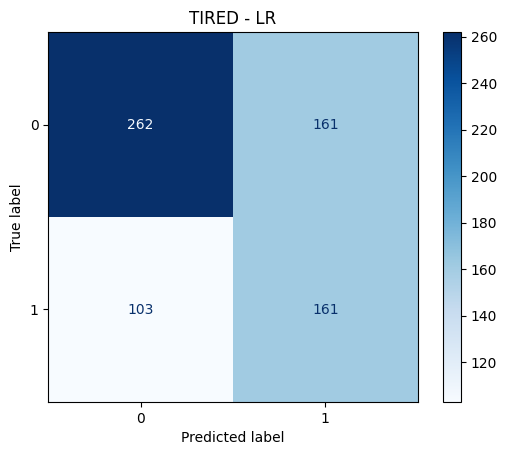

In [56]:
pipe_lr = Pipeline([
    ("preprocess", pre_mlp), #farem servir el mateix preprocessador que mlp
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)


print("Balanced-Acc LR:", balanced_accuracy_score(y_test, y_pred_lr))

pipe_dum = DummyClassifier(strategy="most_frequent")
pipe_dum.fit(X_train, y_train)


print("Dummy accuracy:", pipe_dum.score(X_test, y_test))

run_report('LR', y_pred_lr)


## Entrenament MLP

In [57]:
# Classificador MLP
mlp = MLPClassifier(max_iter=1000, random_state=42)


param_mlp = {
    "clf__hidden_layer_sizes": [(64,), (128,), (64,32)],
    "clf__alpha": np.logspace(-5, -1, 5),
    "clf__learning_rate_init": [1e-3, 5e-3, 1e-2],
}

smote = SMOTENC(
    categorical_features=[X.columns.get_loc(c) for c in cat_feat],
    random_state=42
)

pipe_mlp = ImbPipeline([
    ("prep", pre_mlp),
    ("smote", smote), 
    ("clf", mlp)
    ])

== TIRED - MLP==
              precision    recall  f1-score   support

         0.0       0.67      0.61      0.64       423
         1.0       0.46      0.53      0.49       264

    accuracy                           0.58       687
   macro avg       0.57      0.57      0.57       687
weighted avg       0.59      0.58      0.58       687



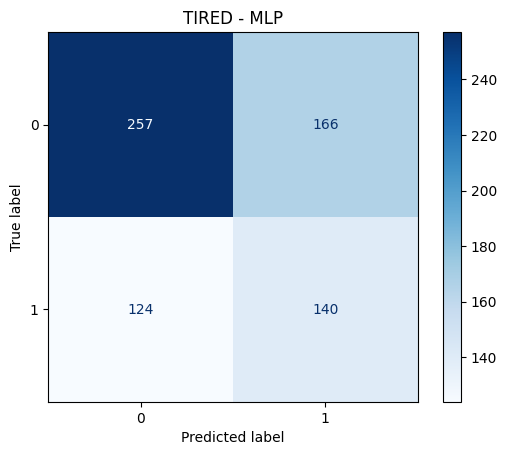

In [58]:
best_mlp = run_grid(pipe_mlp, param_mlp)

y_pred_mlp = best_mlp.predict(X_test)

run_report('MLP', y_pred_mlp)


## ENTRENAMENT GRADIENT BOOSTING

In [59]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()

pipe_gb = Pipeline([
    ("preprocess", pre_tree),
    ("clf", gb)
])
param_gb = {
    "clf__n_estimators": [200, 400],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [2, 3]
}


== TIRED - GB==
              precision    recall  f1-score   support

         0.0       0.66      0.81      0.72       423
         1.0       0.51      0.32      0.40       264

    accuracy                           0.62       687
   macro avg       0.58      0.57      0.56       687
weighted avg       0.60      0.62      0.60       687



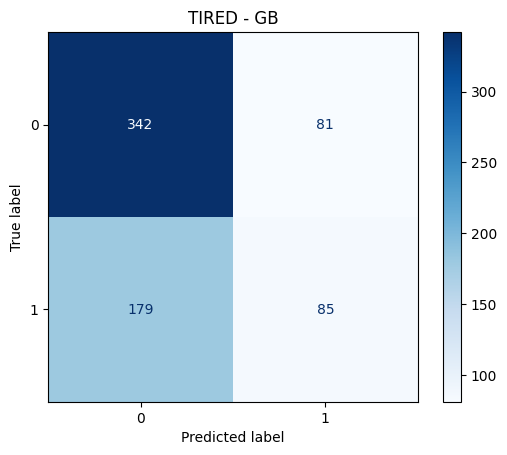

In [60]:
best_gb = run_grid(pipe_gb, param_gb)

y_pred_gb = best_gb.predict(X_test)

run_report('GB', y_pred_gb)

## ENTRENAMENT AMB HistGradientBoostingClassifier

In [61]:
hgb = HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.05, max_iter=400,
        class_weight="balanced", random_state=42)

pipe_hgb = Pipeline([
    ("prep", pre_tree),
    ("clf",  hgb)
])

param_hgb = {
    "clf__max_depth": [3, None],
    "clf__max_iter": [300, 500],
    "clf__learning_rate": [0.05, 0.1],
    "clf__l2_regularization": [0.0, 1.0]
}

== TIRED - HGB==
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68       423
         1.0       0.49      0.50      0.50       264

    accuracy                           0.61       687
   macro avg       0.59      0.59      0.59       687
weighted avg       0.61      0.61      0.61       687



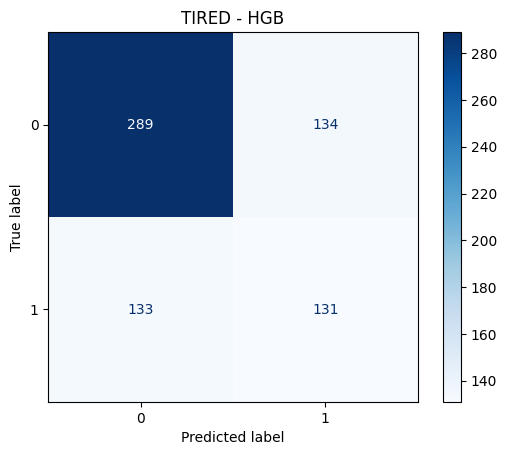

In [62]:
best_hgb = run_grid(pipe_hgb, param_hgb)

y_pred_hgb = best_hgb.predict(X_test)

run_report('HGB', y_pred_hgb)


HGB umbral ajustat  —  thr=0.17  P=0.39  R=0.99  F1=0.56
              precision    recall  f1-score   support

         0.0       0.78      0.02      0.03       423
         1.0       0.39      0.99      0.56       264

    accuracy                           0.39       687
   macro avg       0.58      0.50      0.29       687
weighted avg       0.63      0.39      0.23       687



(np.float64(0.3864306784660767),
 np.float64(0.9924242424242424),
 np.float64(0.5562632696386623))

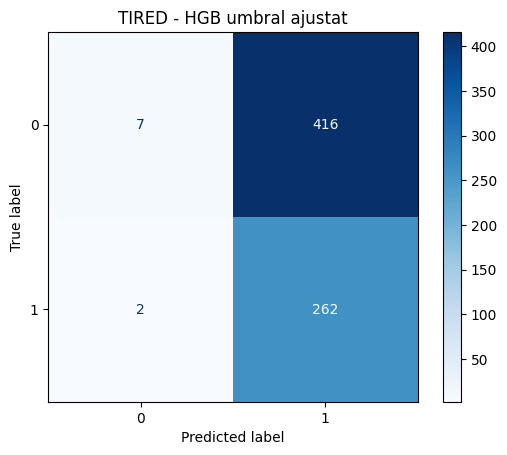

In [63]:
ajust_umbral(best_hgb, 'HGB umbral ajustat')

## BALANCED RANDOM FOREST

In [64]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(
        n_estimators=1000, max_depth=None, random_state=42,
        sampling_strategy="auto")          # sub‑samplea la clase mayoritaria

pipe_brf = Pipeline([("prep", pre_tree), ("clf", brf)])

param_brf = {
    "clf__max_depth": [5, None],
    "clf__min_samples_leaf": [1, 5],
    "clf__n_estimators": [400, 800]
}


== TIRED - BRF==
              precision    recall  f1-score   support

         0.0       0.73      0.40      0.51       423
         1.0       0.44      0.76      0.56       264

    accuracy                           0.54       687
   macro avg       0.58      0.58      0.54       687
weighted avg       0.62      0.54      0.53       687



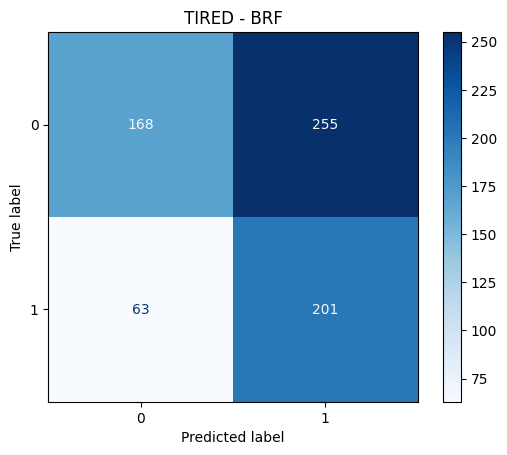

In [65]:
best_brf = run_grid(pipe_brf, param_brf)

y_pred_brf = best_brf.predict(X_test)

run_report('BRF', y_pred_brf)


BRF- umbral ajustat  —  thr=0.32  P=0.43  R=0.86  F1=0.58
              precision    recall  f1-score   support

         0.0       0.78      0.30      0.43       423
         1.0       0.43      0.86      0.58       264

    accuracy                           0.51       687
   macro avg       0.60      0.58      0.50       687
weighted avg       0.64      0.51      0.49       687



(np.float64(0.43346007604562736),
 np.float64(0.8636363636363636),
 np.float64(0.5772151898729726))

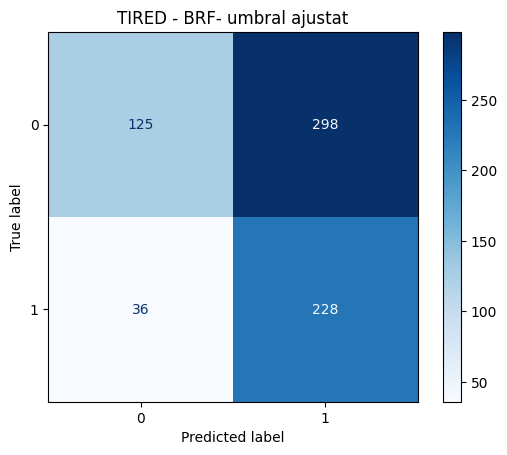

In [66]:
ajust_umbral(best_brf, 'BRF- umbral ajustat')


In [67]:
pipe_xgb = Pipeline([
    ("prep", pre_tree),
    ("clf", XGBClassifier(
        eval_metric="logloss",
        scale_pos_weight = y_train.value_counts()[0]/y_train.value_counts()[1],
        random_state=42))
])
param_xgb = {
    "clf__n_estimators": [500, 800],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 4]
}


== TIRED - XGB==
              precision    recall  f1-score   support

         0.0       0.68      0.69      0.68       423
         1.0       0.49      0.48      0.48       264

    accuracy                           0.61       687
   macro avg       0.58      0.58      0.58       687
weighted avg       0.61      0.61      0.61       687



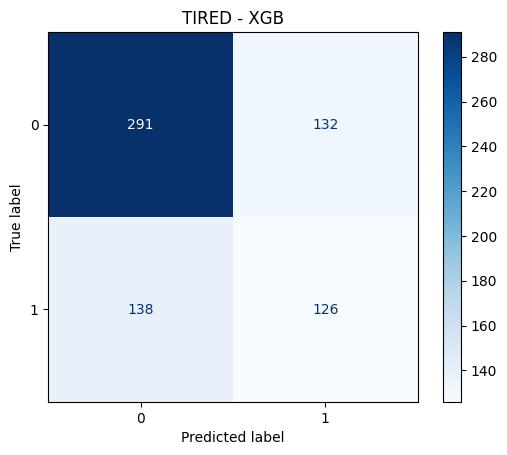

In [68]:
best_xgb = run_grid(pipe_xgb, param_xgb)

y_pred_xgb = best_xgb.predict(X_test)

run_report('XGB', y_pred_xgb)


XGB  —  thr=0.30  P=0.40  R=0.92  F1=0.56
              precision    recall  f1-score   support

         0.0       0.75      0.14      0.24       423
         1.0       0.40      0.92      0.56       264

    accuracy                           0.44       687
   macro avg       0.57      0.53      0.40       687
weighted avg       0.61      0.44      0.36       687



(np.float64(0.40131578947368424),
 np.float64(0.9242424242424242),
 np.float64(0.5596330275225135))

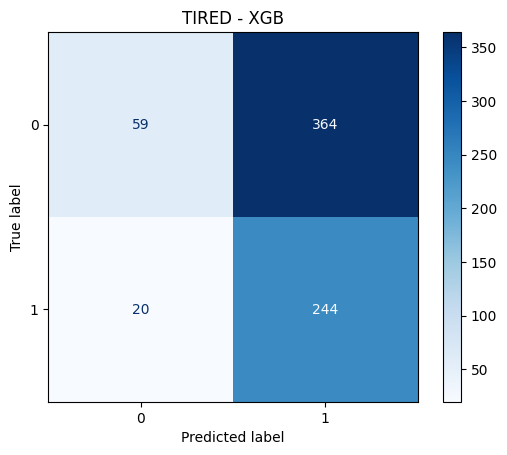

In [69]:
ajust_umbral(best_xgb, "XGB")

In [70]:
from lightgbm import LGBMClassifier
pipe_lgb = Pipeline([
    ("prep", pre_tree),
    ("clf",  LGBMClassifier(objective="binary", is_unbalance=True, random_state=42))
    ])

param_lgb = {
    "clf__n_estimators": [400, 800, 1200],
    "clf__learning_rate": [0.03, 0.05, 0.1],
    "clf__num_leaves": [15, 31, 63],
    "clf__min_child_samples": [20, 50]
}
best_lgb = run_grid(pipe_lgb, param_lgb)

[LightGBM] [Info] Number of positive: 616, number of negative: 987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3802
[LightGBM] [Info] Number of data points in the train set: 1603, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384279 -> initscore=-0.471423
[LightGBM] [Info] Start training from score -0.471423


== TIRED - LGB==
              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69       423
         1.0       0.49      0.47      0.48       264

    accuracy                           0.61       687
   macro avg       0.58      0.58      0.58       687
weighted avg       0.60      0.61      0.61       687



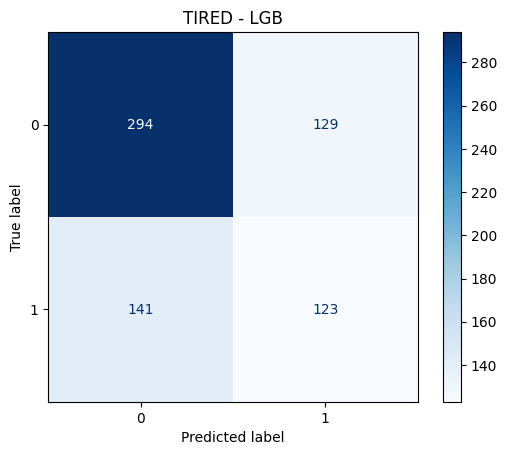

In [71]:
y_pred_lgb = best_lgb.predict(X_test)

run_report('LGB', y_pred_lgb)

[LightGBM] [Info] Number of positive: 410, number of negative: 658
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3728
[LightGBM] [Info] Number of data points in the train set: 1068, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383895 -> initscore=-0.473048
[LightGBM] [Info] Start training from score -0.473048
[LightGBM] [Info] Number of positive: 411, number of negative: 658
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3712
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384471 -> initscore=-0.470612
[LightGBM] [Info] Start training from score -0.470612
[LightGBM] [Info] Numb

(np.float64(0.4073455759599332),
 np.float64(0.9242424242424242),
 np.float64(0.5654692931629588))

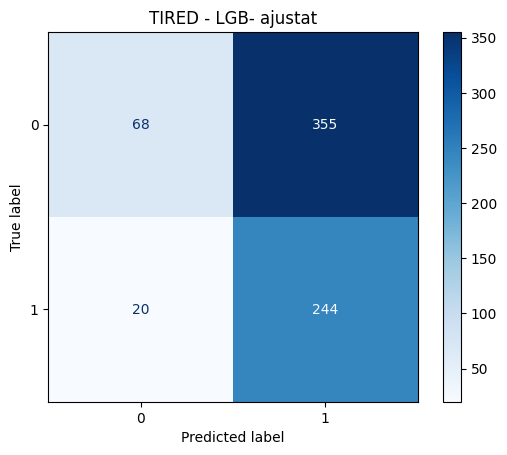

In [72]:
ajust_umbral(best_lgb, 'LGB- ajustat')